In [1]:
from keras.layers import *
import tensorflow.keras.backend as K
import numpy as np
from keras import optimizers, Model
from keras.utils import Sequence
from numpy.random import seed
import math
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
import time
from keras.callbacks import TensorBoard
from utils import *

ModuleNotFoundError: No module named 'keras'

In [2]:
# Build Channel Attention Block
def eca_block(tensor, b=1, gama=8):
    init = tensor
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = init.shape[channel_axis]
    eca_shape = (1,filters)
    init1 = Reshape(target_shape=(eca_shape))(init)   
    in_channel=1
    
    kernel_size = int(abs((math.log(in_channel, 2) + b) / gama))
    
    if kernel_size % 2:
        kernel_size = kernel_size
    
    else:
        kernel_size = kernel_size + 1
    
    x = GlobalAveragePooling1D()(init1)
    x = Reshape(eca_shape)(x)

    x = Conv1D(filters=1, kernel_size=kernel_size, padding='same', use_bias=False)(x) 
    print('k size 1:', kernel_size)
    x = tf.nn.relu(x)
    x = Conv1D(filters=1, kernel_size=kernel_size, padding='same', use_bias=False)(x)  
    print('k size 2:', kernel_size)
    x = tf.nn.sigmoid(x)    
    x = Reshape((1,1,in_channel))(x)
    #x = GlobalAveragePooling1D()(x)
    
    outputs = multiply([init1, x])
    outputs = tf.keras.backend.squeeze(outputs,1)
    # outputs = GlobalAveragePooling1D()(outputs)
    return outputs


def remove_columns_kurtosis(matrix, alpha):
    from scipy.stats import kurtosis
    kurtosis = kurtosis(matrix, axis=1)
    
    threshold = np.percentile(kurtosis, alpha*100)
    
    selected_columns = kurtosis > threshold

    return matrix[selected_columns, :]

def inception_res(input_tensor):
    e0 = input_tensor

    e1 = Conv1D(1, 1, padding='same')(e0)
    e1 = Conv1D(1, 3, padding='same', activation='tanh')(e1)
    e1 = Conv1D(1, 3, padding='same', activation='tanh')(e1)
    e1 = BatchNormalization()(e1)
    
    e2 = Conv1D(1, 1, padding='same')(e0)
    e2 = Conv1D(1, 3, padding='same', activation='tanh')(e2)
    e2 = BatchNormalization()(e2)

    e3 = Conv1D(1, 1, padding='same')(e0)
    e3 = BatchNormalization()(e3)
    
    con = Concatenate()([e1, e2, e3])
    con = Conv1D(1, 1, padding='same')(con)

    con_1 = Add()([con, e0])
    # out_tensor = tf.nn.PReLU(con_1)

    return(con_1)

def mff_block(input_tensor, filters, kernel_size, strides):
    e1 = Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(input_tensor)
    e1 = BatchNormalization()(e1)
    e1 = PReLU()(e1)

    e2 = Conv1D(filters=filters, kernel_size=kernel_size+3, strides=strides+2, padding='same')(input_tensor)
    e2 = BatchNormalization()(e2)
    e2 = PReLU()(e2)

    con_e = concatenate([e2, e1], axis=-1)
    out_con = Conv1D(1, 1, activation='tanh')(con_e)
    out_con = Add()([out_con, input_tensor])
    # outputs = tf.nn.PReLU(out_con)

    return out_con

In [3]:
file_path = '/home/g202321530/Yang/Project/DAS_coupling/Data/raw/npy_raw_1/'   
eq_num = 3
file_name = f'eq-{eq_num}'

# Load Data and Patches
w1=24
w2=24
z1=6
z2=6
batch = 1024
drop_rate = 0.15

# data = np.load('./synthetic_data/syn_das_pure_noisy_data_3.npy')
data = np.load(f'{file_path}{file_name}.npy')
print(data.shape)
# plt.imshow(data, cmap='seismic', vmin=-20, vmax=20)
dataNoise = yc_patch(data, w1, w2, z1, z2)
dataNoise1 = remove_columns_kurtosis(dataNoise, drop_rate)
print(dataNoise.shape, dataNoise1.shape)
INPUT_SIZE1 = dataNoise.shape[0]
INPUT_SIZE2 = dataNoise.shape[1]
input_img = Input(shape=(INPUT_SIZE2,))
print(INPUT_SIZE2,"INPUTR_SIZE2")
input_img1 = input_img[:,:, tf.newaxis]
print(input_img1.shape)

(960, 2000)
(51967, 576) (44172, 576)
576 INPUTR_SIZE2
(None, 576, 1)


2024-09-01 13:22:42.521724: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-01 13:22:42.521938: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-01 13:22:42.551030: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
# Building the DIP model.
D1 = 128
D2 = D1/4 #32
D3 = D2/4 #8
D4 = int(D3/2) #2
print(D1,D2,D3,D4)
k = 3
s = 3

input_img1 = input_img[:,tf.newaxis]
# Encoder
encoded1 = Conv1D(filters=D1, kernel_size=k, padding='same', name='e1')(input_img1)
encoded1 = BatchNormalization()(encoded1)
encoded1 = PReLU()(encoded1)
encoded1x = Conv1D(filters=D1, kernel_size=k+3, padding='same', name='e11')(input_img1)
#encoded1x = BatchNormalization()(encoded1x)
encoded1x = PReLU()(encoded1x)
encoded1x = concatenate([encoded1x, encoded1], axis=-1)
encoded1x = Dense(D1)(encoded1x)
encoded1x = PReLU()(encoded1x)


skip1 = eca_block(encoded1x)


encoded2 = Conv1D(filters=D2, kernel_size=k, padding='same', name='e2')(encoded1x)
encoded2 = BatchNormalization()(encoded2)
encoded2 = PReLU()(encoded2)
encoded2x = Conv1D(filters=D2, kernel_size=k+3, padding='same', name='e22')(encoded1x)
#encoded2x = BatchNormalization()(encoded2x)
encoded2x = PReLU()(encoded2x)
encoded2x = concatenate([encoded2x, encoded2], axis=-1)
encoded2x = Dense(D2)(encoded2x)
encoded2x = PReLU()(encoded2x)


skip2 = eca_block(encoded2x)


encoded3 = Conv1D(filters=D3, kernel_size=k, padding='same', name='e3')(encoded2x)
encoded3 = BatchNormalization()(encoded3)
encoded3 = PReLU()(encoded3)
encoded3x = Conv1D(filters=D3, kernel_size=k+3, padding='same', name='e33')(encoded2x)
#encoded3x = BatchNormalization()(encoded3x)
encoded3x = PReLU()(encoded3x)
encoded3x = concatenate([encoded3x, encoded3], axis=-1)
encoded3x = Dense(D3)(encoded3x)
encoded3x = PReLU()(encoded3x)

skip3 = eca_block(encoded3x)

# # Decoder
decoded3 = Conv1D(filters=D3, kernel_size=k, padding='same', name='d3')(encoded3x)
decoded3 = BatchNormalization()(decoded3)
decoded3 = PReLU()(decoded3)
decoded3x = Conv1D(filters=D3, kernel_size=k+3, padding='same', name='d33')(encoded3x)
#decoded3x = BatchNormalization()(decoded3x)
decoded3x = PReLU()(decoded3x)
decoded3x = concatenate([decoded3x, decoded3], axis=-1)
decoded3x = Dense(D3)(decoded3x)
decoded3x = PReLU()(decoded3x)


decoded3xx = concatenate([decoded3x, skip3])


decoded2 = Conv1D(filters=D2, kernel_size=k, padding='same', name='d2')(decoded3xx)
decoded2 = BatchNormalization()(decoded2)
decoded2 = PReLU()(decoded2)
decoded2x = Conv1D(filters=D2, kernel_size=k+3, padding='same', name='d22')(encoded2x)
#decoded2x = BatchNormalization()(decoded2x)
decoded2x = PReLU()(decoded2x)
decoded2x = concatenate([decoded2x, decoded2], axis=-1)
decoded2x = Dense(D2)(decoded2x)
decoded2x = PReLU()(decoded2x)


decoded2xx = concatenate([decoded2x, skip2])

decoded1 = Conv1D(filters=D1, kernel_size=k, padding='same', name='d1')(decoded2xx)
decoded1 = BatchNormalization()(decoded1)
decoded1 = PReLU()(decoded1)
decoded1x = Conv1D(filters=D1, kernel_size=k+3, padding='same', name='d11')(decoded2xx)
#decoded1x = BatchNormalization()(decoded1x)
decoded1x = PReLU()(decoded1x)
decoded1x = concatenate([decoded1x, decoded1], axis=-1)
decoded1x = Dense(D1)(decoded1x)
decoded1x = PReLU()(decoded1x)


decoded1xx = concatenate([decoded1x, skip1])


decoded1xx = Conv1D(INPUT_SIZE2/3, 1, 1, padding='same')(decoded1xx)
decoded = Conv1D(INPUT_SIZE2, 1, padding='same')(decoded1xx)
decoded = Flatten()(decoded)


autoencoder = Model(input_img, decoded)
optimizer = optimizers.Adam(lr=0.01)


autoencoder.compile(optimizer=optimizer, loss='MSE')
autoencoder.summary()

128 32.0 8.0 4
k size 1: 1
k size 2: 1
k size 1: 1
k size 2: 1
k size 1: 1
k size 2: 1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 576)]                0         []                            
                                                                                                  
 tf.__operators__.getitem_1  (None, 1, 576)               0         ['input_1[0][0]']             
  (SlicingOpLambda)                                                                               
                                                                                                  
 e1 (Conv1D)                 (None, 1, 128)               221312    ['tf.__operators__.getitem_1[0
                                                                    ][0]']                        
                                                                                              

In [5]:
# Addig stopping condition
model_path = "/home/g202321530/Yang/Project/DAS_coupling/Data/model/FORGE/"
es=EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
mc=ModelCheckpoint(f'{model_path}FORGE_model_{file_name}_p{w1}_s{z1}_drop_{drop_rate}.h5', monitor='loss', mode='min', save_best_only=True)

batch=1024
epoch = 80 
history = autoencoder.fit(dataNoise1, dataNoise1, verbose=1, epochs=epoch, batch_size=batch, shuffle=True, callbacks=[es, mc], validation_split=0.1)

Epoch 1/80


2024-09-01 13:22:47.012824: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-09-01 13:22:48.194396: I external/local_xla/xla/service/service.cc:168] XLA service 0x7a8e5917eea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-01 13:22:48.194415: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4500, Compute Capability 8.6
2024-09-01 13:22:48.194420: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A4500, Compute Capability 8.6
2024-09-01 13:22:48.197687: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1725186168.250847 3115827 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


39/39 [==============================] - 13s 104ms/step - loss: 546.4872 - val_loss: 543.6855
Epoch 2/80
 1/39 [..............................] - ETA: 0s - loss: 443.9648

/home/g202321530/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


39/39 [==============================] - 1s 21ms/step - loss: 409.9671 - val_loss: 448.4760
Epoch 3/80
39/39 [==============================] - 1s 25ms/step - loss: 344.1955 - val_loss: 387.8972
Epoch 4/80
39/39 [==============================] - 1s 21ms/step - loss: 306.4041 - val_loss: 344.8898
Epoch 5/80
39/39 [==============================] - 1s 19ms/step - loss: 281.7652 - val_loss: 315.7510
Epoch 6/80
39/39 [==============================] - 1s 19ms/step - loss: 264.5437 - val_loss: 293.3798
Epoch 7/80
39/39 [==============================] - 1s 20ms/step - loss: 251.0241 - val_loss: 275.1387
Epoch 8/80
39/39 [==============================] - 1s 19ms/step - loss: 239.7631 - val_loss: 260.5175
Epoch 9/80
39/39 [==============================] - 1s 19ms/step - loss: 230.5660 - val_loss: 248.8789
Epoch 10/80
39/39 [==============================] - 1s 19ms/step - loss: 223.0553 - val_loss: 239.5092
Epoch 11/80
39/39 [==============================] - 1s 19ms/step - loss: 216.4291 

In [6]:
def localsimi(d1,d2,rect,niter=50,eps=0.0,verb=1):

	import numpy as np
	
	if d1.ndim==2:
		d1=np.expand_dims(d1, axis=2)
	if d2.ndim==2:
		d2=np.expand_dims(d2, axis=2)
	[n1,n2,n3]=d1.shape

	nd=n1*n2*n3;
	ndat=[n1,n2,n3];
	eps_dv=eps;
	eps_cg=0.1; 
	tol_cg=0.000001;

	ratio = divne(d2, d1, niter, rect, ndat, eps_dv, eps_cg, tol_cg,verb);
	ratio1 = divne(d1, d2, niter, rect, ndat, eps_dv, eps_cg, tol_cg,verb);
	simi=np.sqrt(np.abs(ratio*ratio1));
	return simi
 
def cseis():
    from matplotlib.colors import ListedColormap
    import numpy as np
    seis=np.concatenate(
(np.concatenate((0.5*np.ones([1,40]),np.expand_dims(np.linspace(0.5,1,88),axis=1).transpose(),np.expand_dims(np.linspace(1,0,88),axis=1).transpose(),np.zeros([1,40])),axis=1).transpose(),
np.concatenate((0.25*np.ones([1,40]),np.expand_dims(np.linspace(0.25,1,88),axis=1).transpose(),np.expand_dims(np.linspace(1,0,88),axis=1).transpose(),np.zeros([1,40])),axis=1).transpose(),
np.concatenate((np.zeros([1,40]),np.expand_dims(np.linspace(0,1,88),axis=1).transpose(),np.expand_dims(np.linspace(1,0,88),axis=1).transpose(),np.zeros([1,40])),axis=1).transpose()),axis=1)
    return ListedColormap(seis)


In [7]:
from keras.models import load_model  
model = load_model(f'{model_path}FORGE_model_{file_name}_p{w1}_s{z1}_drop_{drop_rate}.h5')

In [8]:
# patching
data = np.load(f'{file_path}{file_name}.npy')
data = np.transpose(data)
dataNoisy = yc_patch(data, w1, w2, z1, z2)
print(data.shape, dataNoisy.shape)

out_path = '/home/g202321530/Yang/Project/DAS_coupling/python_code/denoised_data/FORGE/'

out = model.predict(dataNoisy)
out = np.transpose(out)
print(out.shape)
# unpatching
n1, n2 = data.shape
predicted = yc_patch_inv(out,n1,n2,w1,w2,z1,z2)
np.save(f'{out_path}denoised_FORGE_{file_name}_p{w1}_s{z1}_drop_{drop_rate}_epoch{epoch}.npy', predicted)


(2000, 960) (51967, 576)
1624/1624 [==============================] - 8s 5ms/step
(576, 51967)


In [9]:
import matplotlib.pyplot as plt

simi_out_path = '/home/g202321530/Yang/Project/DAS_coupling/python_code/denoised_data/FORGE/simi/'

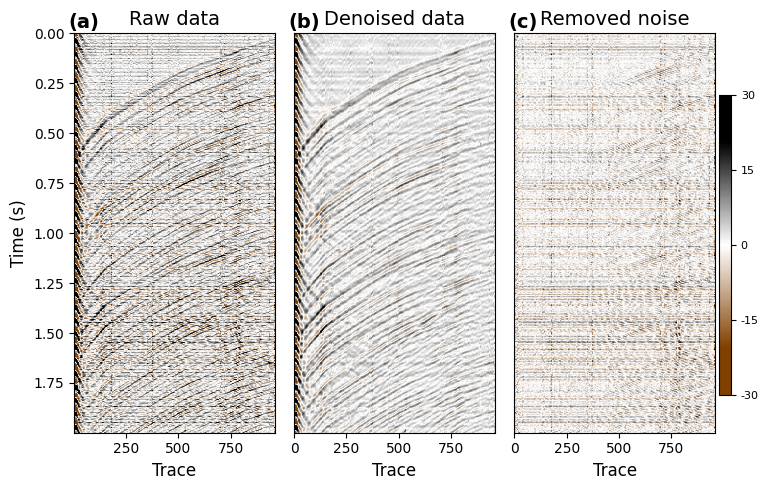

In [10]:
## plot figures
fig_path = '/home/g202321530/Yang/Project/DAS_coupling/python_code/denoised_fig/FORGE/'
v = 30
xx, yy = 100, 0.04
v1 = 1

num_samples = len(data[:, 1])
num_samples_x = len(data[1, :])
time_interval = 0.001
time = np.arange(0, num_samples) * time_interval


mm = -0.03
nn = 1.05

fig = plt.figure(figsize=(8,5))
ax4 = fig.add_subplot(1,3,1)
plt.imshow(data,cmap=cseis(), vmin=-v, vmax=v,aspect='auto', extent=(1, num_samples_x, time[-1], 0)); 
plt.xlabel("Trace", fontsize=12)
plt.ylabel("Time (s)", fontsize=12)
plt.title('Raw data', fontsize=14);
# plt.annotate('(a)', xy=(0.05, 0.95), xytext=(-xx, -yy), fontsize=14, fontweight='bold', va='top')
ax4.annotate('(a)', xy=(mm, nn), xycoords='axes fraction', fontsize=14, fontweight='bold', va='top')

ax1 = fig.add_subplot(1,3,2)
plt.imshow(predicted,cmap=cseis(), vmin=-v, vmax=v, aspect='auto', extent=(0, num_samples_x, time[-1], 0));
plt.xlabel("Trace", fontsize=12)
plt.yticks([])
plt.title('Denoised data', fontsize=14);
# plt.annotate('(b)', xy=(0, 0), xytext=(-xx, -yy), fontsize=14, fontweight='bold', va='top')
ax1.annotate('(b)', xy=(mm, nn), xycoords='axes fraction', fontsize=14, fontweight='bold', va='top')

ax2 = fig.add_subplot(1,3,3)
ax2 = plt.imshow(data-predicted,cmap=cseis(), vmin=-v, vmax=v, aspect='auto',  extent=(0, num_samples_x, time[-1], 0));
plt.xlabel("Trace", fontsize=12)
plt.yticks([])
plt.title('Removed noise', fontsize=14)
# plt.annotate('(c)', xy=(0, 0), xytext=(-xx, -yy), fontsize=14, fontweight='bold', va='top')
plt.annotate('(c)', xy=(mm, nn), xycoords='axes fraction', fontsize=14, fontweight='bold', va='top')


plt.tight_layout()



plt.tight_layout()
# %mkdir denoised_fig

fig.subplots_adjust(right=0.9)

l = 0.905
b = 0.2
w = 0.015
h = 1 - 2*b 

rect = [l,b,w,h] 
cbar_ax = fig.add_axes(rect) 
cb = plt.colorbar(ax2, cax=cbar_ax)
cb.ax.tick_params(labelsize=8) 
num_ticks = 5
cbar_ticks = np.linspace(-v, v, num_ticks)
cb.set_ticks(cbar_ticks)

# Optionally set tick labels
cb.set_ticklabels([f'{tick:.0f}' for tick in cbar_ticks])
# plt.tight_layout()


plt.savefig(f'{fig_path}{file_name}_p{w1}_s{z1}_drop_{drop_rate}_epoch{epoch}_colormap_1.png', dpi=200)
plt.savefig(f'{fig_path}{file_name}_p{w1}_s{z1}_drop_{drop_rate}_epoch{epoch}_colormap_1.pdf', dpi=200)
#plt.savefig(f'{fig_path}{file_name}_p{w1}_s{z1}_drop_{drop_rate}_epoch{epoch}_colormap_1.eps', dpi=200)
plt.show()

In [11]:
fig = plt.figure(figsize=(3.5,5))
# ax1 = fig.add_subplot(1,4,1)
plt.imshow(simi1,cmap='jet', vmin=0, vmax=1, aspect='auto', extent=(0, num_samples_x, time[-1], 0));
plt.xlabel("Trace", fontsize=12)
plt.ylabel("Time (s)", fontsize=12)
plt.title('Similarity Map', fontsize=14); 
plt.colorbar(shrink=0.6)
plt.tight_layout()

plt.savefig(f'{fig_path}simi_{file_name}_p{w1}_s{z1}_drop_{drop_rate}_epoch{epoch}_mean_{np.mean(simi1):.3f}.png', dpi=200)
plt.savefig(f'{fig_path}simi_{file_name}_p{w1}_s{z1}_drop_{drop_rate}_epoch{epoch}_mean_{np.mean(simi1):.3f}.pdf', dpi=200)
#plt.savefig(f'{fig_path}simi_{file_name}_p{w1}_s{z1}_drop_{drop_rate}_epoch{epoch}_mean_{np.mean(simi1):.3f}.eps', dpi=200)

plt.show()

print(f'mean of the local similarity map: {np.mean(simi1):.3f}')

NameError: name 'simi1' is not defined

<Figure size 350x500 with 0 Axes>

In [ ]:
fig = plt.figure(figsize=(8,5))
ax4 = fig.add_subplot(1,3,1)
plt.imshow(data,cmap='seismic', vmin=-v, vmax=v,aspect='auto', extent=(1, num_samples_x, time[-1], 0)); 
plt.xlabel("Trace", fontsize=12)
plt.ylabel("Time (s)", fontsize=12)
plt.title('Raw data', fontsize=14);
# plt.annotate('(a)', xy=(0.05, 0.95), xytext=(-xx, -yy), fontsize=14, fontweight='bold', va='top')
ax4.annotate('(a)', xy=(mm, nn), xycoords='axes fraction', fontsize=14, fontweight='bold', va='top')

ax1 = fig.add_subplot(1,3,2)
plt.imshow(predicted,cmap='seismic', vmin=-v, vmax=v, aspect='auto', extent=(0, num_samples_x, time[-1], 0));
plt.xlabel("Trace", fontsize=12)
plt.yticks([])
plt.title('Denoised data', fontsize=14);
# plt.annotate('(b)', xy=(0, 0), xytext=(-xx, -yy), fontsize=14, fontweight='bold', va='top')
ax1.annotate('(b)', xy=(mm, nn), xycoords='axes fraction', fontsize=14, fontweight='bold', va='top')

ax2 = fig.add_subplot(1,3,3)
ax2 = plt.imshow(data-predicted,cmap='seismic', vmin=-v, vmax=v, aspect='auto',  extent=(0, num_samples_x, time[-1], 0));
plt.xlabel("Trace", fontsize=12)
plt.yticks([])
plt.title('Removed noise', fontsize=14)
# plt.annotate('(c)', xy=(0, 0), xytext=(-xx, -yy), fontsize=14, fontweight='bold', va='top')
plt.annotate('(c)', xy=(mm, nn), xycoords='axes fraction', fontsize=14, fontweight='bold', va='top')

# ax3 = fig.add_subplot(1,4,4)
# ax3=plt.imshow((data-predicted),cmap=cseis(), vmin=-v, vmax=v, aspect='auto',  extent=(0, num_samples_x, time[-1], 0));
# plt.xlabel("Trace", fontsize=12)
# plt.yticks([])
# plt.title('Removed noise');
# # plt.annotate('(d)', xy=(0, 0), xytext=(-xx, -yy), fontsize=14, fontweight='bold', va='top')
# plt.annotate('(d)', xy=(mm, nn), xycoords='axes fraction', fontsize=14, fontweight='bold', va='top')

plt.tight_layout()



plt.tight_layout()
# %mkdir denoised_fig

fig.subplots_adjust(right=0.9)

l = 0.905
b = 0.2
w = 0.015
h = 1 - 2*b 

rect = [l,b,w,h] 
cbar_ax = fig.add_axes(rect) 
cb = plt.colorbar(ax2, cax=cbar_ax)
cb.ax.tick_params(labelsize=8) 
num_ticks = 5
cbar_ticks = np.linspace(-v, v, num_ticks)
cb.set_ticks(cbar_ticks)

# Optionally set tick labels
cb.set_ticklabels([f'{tick:.0f}' for tick in cbar_ticks])
# plt.tight_layout()


plt.savefig(f'{fig_path}{file_name}_p{w1}_s{z1}_drop_{drop_rate}_epoch{epoch}_colormap_seis.png', dpi=200)
plt.savefig(f'{fig_path}{file_name}_p{w1}_s{z1}_drop_{drop_rate}_epoch{epoch}_colormap_seis.pdf', dpi=200)
#plt.savefig(f'{fig_path}{file_name}_p{w1}_s{z1}_drop_{drop_rate}_epoch{epoch}_colormap_seis.eps', dpi=200)
plt.show()

### 